# **차량 공유업체의 차량 파손 여부 분류하기**

## 0.미션

* 1) 미션1 : Data Preprocessing
    - **과제 수행 목표**
        - 모델링 수행을 위해 적절한 폴더 및 파일로 **일관성 있게 정리**해야 합니다.
        - 제공된 데이터 : Car_Images.zip
            * Car_Images : 차량의 정상/파손 이미지 무작위 수집

* 2) 미션2 : CNN 모델링
    - **과제 수행 목표**
        - Tensorflow Keras를 이용하여 모델을 3개 이상 생성하세요.
            - 모델 구조와 파라미터는 자유롭게 구성하세요.
            - 단, 세부 목차에서 명시한 부분은 지켜주세요.

* 3) 미션3 : Data Augmentation & Transfer Learning
    - **과제 수행 목표**
        - 성능 개선을 위해 다음의 두가지를 시도하세요.
            * Data Augmentation을 적용하세요.(Image Generator)
            * Transfer Learning(VGG16)
* 성능 가이드
    * Accuracy : 0.34~0.74

## 1.환경설정

* **세부 요구사항**
    - 경로 설정 : 다음의 두가지 방법 중 하나를 선택하여 폴더를 준비하고 데이터를 로딩하시오.
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.

### (1) 경로 설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### (2) 라이브러리 불러오기

In [2]:
import zipfile, os, random, shutil, glob, yaml, json
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

### (3) 데이터 불러오기

#### 1) 데이터 압축 해제

In [3]:
path = '/content/drive/MyDrive/Colab Notebooks/KT AIVLE/미니 프로젝트/6차 미프/데이터/'

In [4]:
file1 = 'Car_Images.zip'
path + file1

'/content/drive/MyDrive/Colab Notebooks/KT AIVLE/미니 프로젝트/6차 미프/데이터/Car_Images.zip'

In [5]:
# 압축 해제
data = zipfile.ZipFile(path+file1)

try :
    print('압축을 해제합니다.')
    data.extractall(path)
    print('압축 해제가 완료되었습니다.')
except :
    pass
    print('압축이 이미 해제되었거나 이미 폴더가 존재합니다.')

압축을 해제합니다.
압축 해제가 완료되었습니다.


#### 2) 데이터 조회

In [6]:
# 폴더별 이미지 데이터 갯수 확인
print(f"정상 차량 이미지 데이터는 {len(glob.glob(path+'normal/*'))}장 입니다.")
print(f"파손 차량 이미지 데이터는 {len(glob.glob(path+'abnormal/*'))}장 입니다.")

정상 차량 이미지 데이터는 302장 입니다.
파손 차량 이미지 데이터는 303장 입니다.


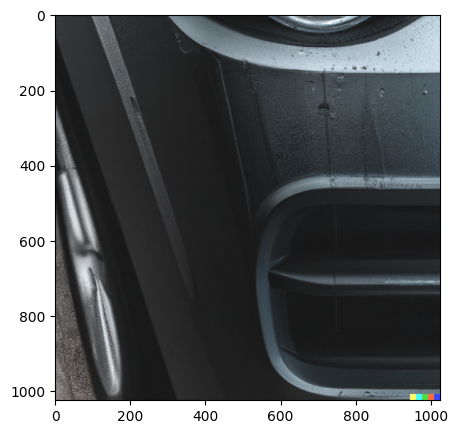

이미지 데이터의 형태는 다음과 같습니다 : (1024, 1024, 3)


In [7]:
# 정상 차량 랜덤 이미지 확인 및 형태 확인

rand_n = random.randint( 0, len(glob.glob(path+'normal/*'))-1 )

plt.figure(figsize=(5,5))
img = plt.imread(glob.glob(path+'normal/*')[rand_n])
plt.imshow(img)
plt.show()

print(f'이미지 데이터의 형태는 다음과 같습니다 : {img.shape}')

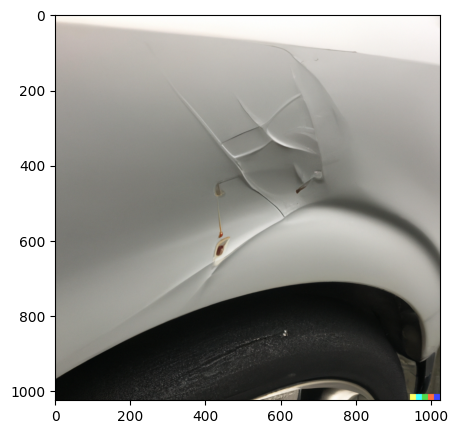

이미지 데이터의 형태는 다음과 같습니다 : (1024, 1024, 3)


In [8]:
# 파손 차량 랜덤 이미지 확인 및 형태 확인

rand_n = random.randint( 0, len(glob.glob(path+'abnormal/*'))-1 )

plt.figure(figsize=(5,5))
img = plt.imread(glob.glob(path+'abnormal/*')[rand_n])
plt.imshow(img)
plt.show()

print(f'이미지 데이터의 형태는 다음과 같습니다 : {img.shape}')

## 2.데이터 전처리

### (1) 모델링 I용 전처리
* 모델링을 위한 데이터 구조 만들기
    * X : 이미지를 array로 변환합니다.
    * Y : 이미지 갯수만큼 normal - 0, abnormal - 1 로 array를 만듭니다.

#### 1) X : 데이터 리스트 통합
- **세부요구사항**
    - 전체 이미지 데이터를 하나의 리스트로 통합합니다.

In [9]:
X = []  # 이미지 데이터를 저장할 빈 리스트

normal_data_1 =glob.glob(path+'normal/*')[:]
abnormal_data_2 = glob.glob(path+'abnormal/*')[:]

X.extend(normal_data_1)
X.extend(abnormal_data_2)

print(len(X))

605


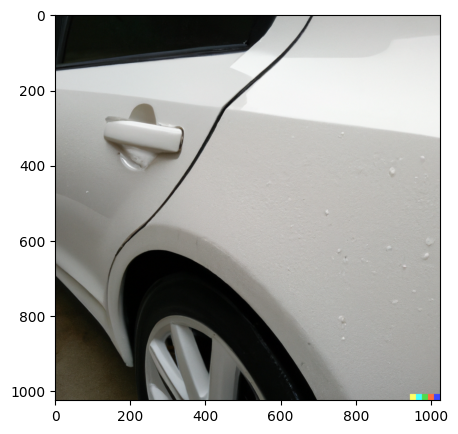

이미지 데이터의 형태는 다음과 같습니다 : (1024, 1024, 3)


In [10]:
# 통합한 뒤 이미지 랜덤으로 잘 나오나 확인
rand_n = random.randint( 0, len(X)-1 )

plt.figure(figsize=(5,5))
img = plt.imread(X[rand_n])
plt.imshow(img)
plt.show()

print(f'이미지 데이터의 형태는 다음과 같습니다 : {img.shape}')

#### 2) X : image to array
- **세부요구사항**
    * 모델링을 위해서는 np.array 형태로 데이터셋을 만들어야 합니다.
    * Training set / Validation set / Test set의 X는 이미지 형태로 되어있습니다.
    * 이미지 파일을 불러와 Training data, Validation data, Test data 각각 array 형태로 변환해 봅시다.
        * 각 폴더로 부터 이미지 목록을 만들고
        * 이미지 한장씩 적절한 크기로 로딩하여 (keras.utils.load_img)
            * 이미지가 너무 크면 학습시간이 많이 걸리고, 메모리 부족현상이 발생될 수 있습니다.
            * 이미지 크기를 280 * 280 * 3 이내의 크기를 설정하여 로딩하시오.
            * array로 변환 (keras.utils.img_to_array, np.expand_dims)
        * 데이터셋에 추가합니다.(데이터셋도 array)

In [11]:
from keras.preprocessing.image import load_img, img_to_array

# 이미지 데이터를 로드, 크기 조정 및 배열로 변환하는 함수
def load_and_preprocess_images(image_paths):
    images = []
    for image_path in image_paths:
        img = load_img(image_path, target_size=(280, 280))
        img_array = img_to_array(img)
        img_array /= 255.0  # 이미지 데이터를 0에서 1 사이의 값으로 스케일 조정
        images.append(img_array)
    return np.array(images)

X = load_and_preprocess_images(X)

len(X)

605

#### 3) Y : 클래스 만들기
- **세부요구사항**
    - 전체 데이터에 대한 Y를 생성합니다.
    - normal, abnormal 데이터의 수를 확인하고 normal을 0, abnormal을 1로 지정합니다.

In [12]:
# 데이터 갯수 확인
print(f"정상 차량 이미지 데이터는 {len(glob.glob(path+'normal/*'))}장 입니다.")
print(f"파손 차량 이미지 데이터는 {len(glob.glob(path+'abnormal/*'))}장 입니다.")

y_normal = [0] * len(glob.glob(path+'normal/*'))
y_abnormal = [1] * len(glob.glob(path+'abnormal/*'))

print(len(y_normal), len(y_abnormal))

Y = y_normal + y_abnormal

정상 차량 이미지 데이터는 302장 입니다.
파손 차량 이미지 데이터는 303장 입니다.
302 303


#### 4) 데이터셋 분리
- **세부요구사항**
    - 데이터 스플릿의 비율은 train set : validation set : test set = 8 : 1: 1 로 설정하세요.

In [13]:
from sklearn.model_selection import train_test_split

# 이미지 데이터 경로가 담긴 X 리스트를 train, validation, test 세트로 분할
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)  # 8:2 비율로 train, temp로 분할

# 나머지 부분인 temp 세트를 validation과 test로 분할
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)  # 1:1 비율로 validation, test로 분할

y_train = np.array(y_train)
y_validation = np.array(y_validation)
y_test = np.array(y_test)

# 각 세트의 길이 확인
print("Train set size:", len(X_train))
print("Validation set size:", len(X_validation))
print("Test set size:", len(X_test))

Train set size: 484
Validation set size: 60
Test set size: 61


## 3.모델링 I
* **세부요구사항**
    * 모델을 최소 3개 이상 만들고 성능을 비교합니다.
        * 모델 학습 과정에 알맞은 보조 지표를 사용하세요.
        * 전처리 과정에서 생성한 Validation set을 적절하게 사용하세요.
        * Early Stopping을 반드시 사용하세요.
            * 최적의 가중치를 모델에 적용하세요.

### (1) 모델 1
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

In [14]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam

#### 1) 구조 설계

In [15]:
# 모델 설계
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(280, 280, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping 설정
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

#### 2) 학습

In [16]:
# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=50, callbacks=[early_stopping])

Epoch 1/50
16/16 [==============================] - 16s 172ms/step - loss: 1.1714 - accuracy: 0.5124 - val_loss: 0.7253 - val_accuracy: 0.5000
Epoch 2/50
16/16 [==============================] - 1s 72ms/step - loss: 0.5401 - accuracy: 0.7231 - val_loss: 0.7699 - val_accuracy: 0.6167
Epoch 3/50
16/16 [==============================] - 1s 72ms/step - loss: 0.4183 - accuracy: 0.8347 - val_loss: 0.8220 - val_accuracy: 0.7500
Epoch 4/50
16/16 [==============================] - 1s 77ms/step - loss: 0.2698 - accuracy: 0.9008 - val_loss: 0.6835 - val_accuracy: 0.7000
Epoch 5/50
16/16 [==============================] - 1s 72ms/step - loss: 0.1943 - accuracy: 0.9360 - val_loss: 1.6438 - val_accuracy: 0.7333
Epoch 6/50
16/16 [==============================] - 1s 72ms/step - loss: 0.1479 - accuracy: 0.9360 - val_loss: 0.8629 - val_accuracy: 0.6667
Epoch 7/50
16/16 [==============================] - 1s 72ms/step - loss: 0.0627 - accuracy: 0.9876 - val_loss: 1.5315 - val_accuracy: 0.7333
Epoch 8/50


#### 3) 성능 평가
* 평가는 confusion_matrix, classification_report 활용

In [17]:
# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

# 예측 및 평가 메트릭 계산
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

2/2 [==============================] - 1s 567ms/step - loss: 0.7231 - accuracy: 0.6721
Test loss: 0.7231
Test accuracy: 0.6721
2/2 [==============================] - 0s 21ms/step
[[24  6]
 [14 17]]
              precision    recall  f1-score   support

           0       0.63      0.80      0.71        30
           1       0.74      0.55      0.63        31

    accuracy                           0.67        61
   macro avg       0.69      0.67      0.67        61
weighted avg       0.69      0.67      0.67        61



### (2) 모델 2
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

#### 1) 구조 설계

In [18]:
### 두 번째 모델

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(280, 280, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0005)

# 모델 컴파일
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=50, callbacks=[early_stopping])

# 예측 및 평가 메트릭 계산
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Epoch 1/50
16/16 [==============================] - 3s 103ms/step - loss: 0.8531 - accuracy: 0.5723 - val_loss: 0.6531 - val_accuracy: 0.8000
Epoch 2/50
16/16 [==============================] - 1s 72ms/step - loss: 0.5474 - accuracy: 0.7934 - val_loss: 0.7588 - val_accuracy: 0.8167
Epoch 3/50
16/16 [==============================] - 1s 73ms/step - loss: 0.4309 - accuracy: 0.8368 - val_loss: 0.6724 - val_accuracy: 0.6167
Epoch 4/50
16/16 [==============================] - 1s 77ms/step - loss: 0.3914 - accuracy: 0.8347 - val_loss: 0.6048 - val_accuracy: 0.7167
Epoch 5/50
16/16 [==============================] - 1s 72ms/step - loss: 0.2351 - accuracy: 0.9132 - val_loss: 0.7644 - val_accuracy: 0.6667
Epoch 6/50
16/16 [==============================] - 1s 72ms/step - loss: 0.1629 - accuracy: 0.9463 - val_loss: 0.8175 - val_accuracy: 0.7167
Epoch 7/50
16/16 [==============================] - 1s 74ms/step - loss: 0.0855 - accuracy: 0.9793 - val_loss: 1.0558 - val_accuracy: 0.7500
Epoch 8/50
1

### (3) 모델 3
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

#### 1) 구조 설계

Epoch 1/50
16/16 [==============================] - 30s 901ms/step - loss: 0.6943 - accuracy: 0.5186 - val_loss: 0.6886 - val_accuracy: 0.7833
Epoch 2/50
16/16 [==============================] - 6s 388ms/step - loss: 0.6217 - accuracy: 0.7045 - val_loss: 1.4039 - val_accuracy: 0.5500
Epoch 3/50
16/16 [==============================] - 6s 395ms/step - loss: 0.6865 - accuracy: 0.6054 - val_loss: 0.6581 - val_accuracy: 0.7333
Epoch 4/50
16/16 [==============================] - 6s 396ms/step - loss: 0.5602 - accuracy: 0.7397 - val_loss: 0.6472 - val_accuracy: 0.6500
Epoch 5/50
16/16 [==============================] - 6s 398ms/step - loss: 0.4691 - accuracy: 0.8017 - val_loss: 0.6247 - val_accuracy: 0.6500
Epoch 6/50
16/16 [==============================] - 6s 396ms/step - loss: 0.4729 - accuracy: 0.7872 - val_loss: 0.7756 - val_accuracy: 0.7833
Epoch 7/50
16/16 [==============================] - 6s 407ms/step - loss: 0.4009 - accuracy: 0.8533 - val_loss: 0.6086 - val_accuracy: 0.6833
Epoch

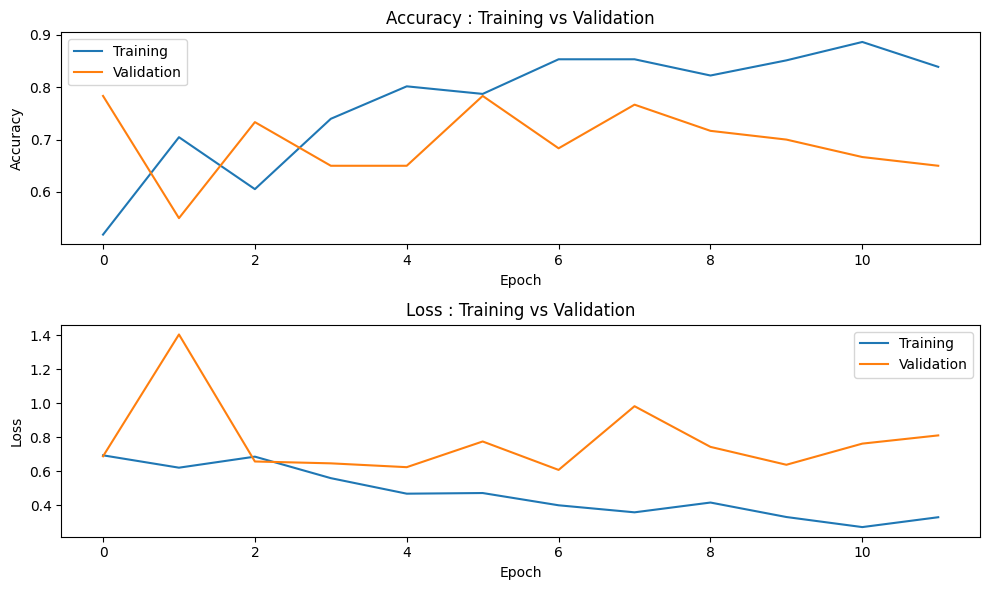

In [19]:
# 세 번째 모델 정의
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(280, 280, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)

# 모델 컴파일
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=50, callbacks=[early_stopping])

# 예측 및 평가 메트릭 계산
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

if not isinstance(history, dict):
    history = history.history

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)

plt.subplot(2, 1, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.tight_layout()
plt.show()

### (2) 모델링 II용 전처리

#### 1) 데이터셋 분리를 위한 폴더 생성
- **세부요구사항**
    - train, validation, test 데이터셋을 만들기 위해 각각 폴더를 생성하고, 하위 폴더 normal과 abnormal을 생성합니다.
        * 정상 이미지 저장소
            - project/Car_Images_train/normal/
            - project/Car_Images_val/normal/
            - project/Car_Images_test/normal/
        * 파손 이미지 저장소
            - project/Car_Images_train/abnormal/
            - project/Car_Images_val/abnormal/
            - project/Car_Images_test/abnormal/
---
- 직접 탐색기에서 폴더를 생성할 수도 있고, os 모듈을 이용하여 코드로 작성할 수도 있습니다.
    - 참고 자료 : [os document](https://docs.python.org/3/library/os.html)

In [20]:
path

'/content/drive/MyDrive/Colab Notebooks/KT AIVLE/미니 프로젝트/6차 미프/데이터/'

In [21]:
import os
# 각각 경로 지정
train_path = path + 'Car_Images_train'
val_path = path + 'Car_Images_val'
test_path = path + 'Car_Images_test'

# train 폴더 만들기 os.mkdir()
if not os.path.exists(train_path):
    os.mkdir(train_path)
    os.mkdir(train_path + '/normal')
    os.mkdir(train_path + '/abnormal')

# test 폴더 만들기 os.mkdir()
if not os.path.exists(test_path):
    os.mkdir(test_path)
    os.mkdir(test_path + '/normal')
    os.mkdir(test_path + '/abnormal')

# validation 폴더 만들기
if not os.path.exists(val_path):
    os.mkdir(val_path)
    os.mkdir(val_path + '/normal')
    os.mkdir(val_path + '/abnormal')

#### 2) 각 폴더에 이미지 데이터 복사
- **세부요구사항**
    - 이전 단계에서 생성한 폴더 normal, abnormal 각각에 이미지 파일을 복사합니다.
    - 데이터 스플릿의 비율은 train set : validation set : test set = 8 : 1 : 1 로 설정하세요.

In [22]:
normal_total = glob.glob(path+'normal/*')
train_normal, tmp = train_test_split(normal_total, test_size=0.2, random_state=42)
test_normal, validation_normal = train_test_split(tmp, test_size=0.5, random_state=42)

abnormal_total = glob.glob(path+'abnormal/*')
train_abnormal, tmp = train_test_split(abnormal_total, test_size=0.2, random_state=42)
test_abnormal, validation_abnormal = train_test_split(tmp, test_size=0.5, random_state=42)

print(len(train_normal), len(test_normal), len(validation_normal))
print(len(train_abnormal), len(test_abnormal), len(validation_abnormal))

241 30 31
242 30 31


In [23]:
train_path = path + 'Car_Images_train'
val_path = path + 'Car_Images_val'
test_path = path + 'Car_Images_test'

import shutil

# 폴더가 이미 존재한다면 삭제하고 폴더 다시 생성
if os.path.exists(train_path):
    shutil.rmtree(train_path)
    os.mkdir(train_path)
    os.mkdir(train_path + '/normal')
    os.mkdir(train_path + '/abnormal')

if os.path.exists(test_path):
    shutil.rmtree(test_path)
    os.mkdir(test_path)
    os.mkdir(test_path + '/normal')
    os.mkdir(test_path + '/abnormal')

if os.path.exists(val_path):
    shutil.rmtree(val_path)
    os.mkdir(val_path)
    os.mkdir(val_path + '/normal')
    os.mkdir(val_path + '/abnormal')

In [24]:
import shutil

# 복사할 이미지 목록을 지정한 폴더로 복사합니다.
# train
for image_path in train_normal:
    image_name = os.path.basename(image_path)
    shutil.copy(image_path, os.path.join(train_path, 'normal', image_name))

for image_path in train_abnormal:
    image_name = os.path.basename(image_path)
    shutil.copy(image_path, os.path.join(train_path, 'abnormal', image_name))

# test
for image_path in test_normal:
    image_name = os.path.basename(image_path)
    shutil.copy(image_path, os.path.join(test_path, 'normal', image_name))

for image_path in test_abnormal:
    image_name = os.path.basename(image_path)
    shutil.copy(image_path, os.path.join(test_path, 'abnormal', image_name))

# validation
for image_path in validation_normal:
    image_name = os.path.basename(image_path)
    shutil.copy(image_path, os.path.join(val_path, 'normal', image_name))

for image_path in validation_abnormal:
    image_name = os.path.basename(image_path)
    shutil.copy(image_path, os.path.join(val_path, 'abnormal', image_name))

#### 3) Y : 클래스 만들기
- **세부요구사항**
    - Test용 데이터에 대한 Y를 생성합니다.
    - normal, abnormal 데이터의 수를 확인하고 normal을 0, abnormal을 1로 지정합니다.

In [25]:
train_path = path + 'Car_Images_train/'
val_path = path + 'Car_Images_val/'
test_path = path + 'Car_Images_test/'

# 데이터 갯수 확인
print(f"정상 차량 이미지 데이터는 {len(glob.glob(test_path + 'normal/*'))}장 입니다.")
print(f"파손 차량 이미지 데이터는 {len(glob.glob(test_path + 'abnormal/*'))}장 입니다.")

y_test_normal = [0] * len(glob.glob(test_path+'normal/*'))
y_test_abnormal = [1] * len(glob.glob(test_path+'abnormal/*'))

print(len(y_test_normal), len(y_test_abnormal))

Y_test = y_test_normal + y_test_abnormal

정상 차량 이미지 데이터는 30장 입니다.
파손 차량 이미지 데이터는 30장 입니다.
30 30


#### 4) X : image to array
- **세부요구사항**
    * 모델링 II에서는 ImageDataGenerator를 이용하기 때문에 Test data에 대해서만 np.array 형태로 데이터셋을 만들어야 합니다.
    * 이미지 파일을 불러와 Test data 각각 array 형태로 변환해 봅시다.
        * 각 폴더로 부터 이미지 목록을 만들고
        * 이미지 한장씩 적절한 크기로 로딩하여 (keras.utils.load_img)
            * 이미지가 너무 크면 학습시간이 많이 걸리고, 메모리 부족현상이 발생될 수 있습니다.
            * 이미지 크기를 280 * 280 * 3 이내의 크기를 설정하여 로딩하시오.
            * array로 변환 (keras.utils.img_to_array, np.expand_dims)
        * 데이터셋에 추가합니다.(데이터셋도 array)

In [26]:
test_path = path + 'Car_Images_test/'

X_test = []  # 이미지 데이터를 저장할 빈 리스트

x_test_normal =glob.glob(test_path+'normal/*')[:]
x_test_abnormal = glob.glob(test_path+'abnormal/*')[:]

X_test.extend(x_test_normal)
X_test.extend(x_test_abnormal)

print(len(X_test))

60


In [27]:
from keras.preprocessing.image import load_img, img_to_array

# 이미지 데이터를 로드, 크기 조정 및 배열로 변환하는 함수
def load_and_preprocess_images(image_paths):
    images = []
    for image_path in image_paths:
        img = load_img(image_path, target_size=(280, 280))
        img_array = img_to_array(img)
        img_array /= 255.0  # 이미지 데이터를 0에서 1 사이의 값으로 스케일 조정
        images.append(img_array)
    return np.array(images)

X_test = load_and_preprocess_images(X_test)

len(X_test)

60

## 4.모델링 II
* **세부요구사항**
    - 성능을 높이기 위해서 다음의 두가지를 시도해 봅시다.
        - Data Augmentation을 통해 데이터를 증가 시킵니다.
        - 사전 학습된 모델(Transfer Learning)을 가져다 사용해 봅시다.

## 증강 모델1

### (1) Data Augmentation
- **세부요구사항**
    * 모델 학습에 이용할 이미지 데이터를 증강시키세요.
    * Keras의 ImageDataGenerator를 이용
        - [ImageDataGenerator document](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

    * ImageDatagenerator를 이용하여 학습
        * 모델 구조는 이미 생성한 1,2,3 중 하나를 선택하여 학습


In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

#### 1) ImageDataGenerator 생성
* ImageDataGenerator 함수 사용
    * 주요 옵션
        * rotation_range: 무작위 회전을 적용할 각도 범위
        * zoom_range: 무작위 줌을 적용할 범위 [1-zoom_range, 1+zoom_range]
        * horizontal_flip: 무작위 좌우반전을 적용할지 여부
        * vertical_flip: 무작위 상하반전을 적용할지 여부
        * rescale: 텐서의 모든 값을 rescale 값으로 나누어줌 (이 경우에는 255로 나누어서 0~1사이의 값으로 변경)

In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator를 초기화합니다.
train_gen = ImageDataGenerator(
    rotation_range=90,  # 이미지 회전 각도 범위
    width_shift_range=0.2,  # 이미지 가로 이동 범위
    height_shift_range=0.2,  # 이미지 세로 이동 범위
    shear_range=0.2,  # 전단변환 범위
    zoom_range=0.2,  # 이미지 확대/축소 범위
    horizontal_flip=True,  # 수평 뒤집기
    fill_mode='nearest',  # 이미지를 증강할 때 사용할 픽셀 채우기 방법
    rescale=1./255,
)

valid_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

#### 2) 데이터 경로에서 이미지 불러 올 준비하기
* .flow_from_directory 이용
    * 디렉토리에서 이미지를 가져와서 데이터 증강을 적용하고 batch 단위로 제공하는 generator를 생성합니다.
    * 이미지를 불러올 때 target_size로 크기를 맞추고,
    * class_mode로 이진 분류(binary)를 수행하도록 지정합니다.


In [49]:
# 이미지 데이터를 불러올 경로 설정
train_path = path + 'Car_Images_train'
val_path = path + 'Car_Images_val'
test_path = path + 'Car_Images_test'

train_generator = train_gen.flow_from_directory(
    train_path,                 # 이미지 데이터를 불러올 디렉토리의 경로
    target_size=(280, 280),     # 이미지를 불러올 때 원하는 크기로 조정
    batch_size=5,  # 원본 이미지당 n개의 이미지를 생성
    class_mode='binary',
    classes=['normal', 'abnormal'],
)

valid_generator = valid_gen.flow_from_directory(
    val_path,
    target_size=(280, 280),
    class_mode='binary',
    classes=['normal', 'abnormal'],
    shuffle=False,
)

test_generator = test_gen.flow_from_directory(
    test_path,
    target_size=(280, 280),
    class_mode='binary',
    classes=['normal', 'abnormal'],
    shuffle=False,
)

Found 483 images belonging to 2 classes.
Found 62 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


#### 3) 구조 설계

In [ ]:
# 모델 정의
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(280, 280, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)

# 모델 컴파일
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

#### 4) 학습

In [ ]:
# 모델 학습
history = model.fit(train_generator, validation_data=(valid_generator), epochs=50, callbacks=[early_stopping]) # generator가 생성하는 이미지만 학습하게 됩니다

Epoch 1/50
16/16 [==============================] - 45s 3s/step - loss: 0.6945 - accuracy: 0.4969 - val_loss: 0.6884 - val_accuracy: 0.5000
Epoch 2/50
16/16 [==============================] - 31s 2s/step - loss: 0.6885 - accuracy: 0.5052 - val_loss: 0.6929 - val_accuracy: 0.6774
Epoch 3/50
16/16 [==============================] - 31s 2s/step - loss: 0.6152 - accuracy: 0.6667 - val_loss: 1.5176 - val_accuracy: 0.6290
Epoch 4/50
16/16 [==============================] - 32s 2s/step - loss: 0.6304 - accuracy: 0.6791 - val_loss: 0.6593 - val_accuracy: 0.6935
Epoch 5/50
16/16 [==============================] - 32s 2s/step - loss: 0.6606 - accuracy: 0.7226 - val_loss: 0.6487 - val_accuracy: 0.7097
Epoch 6/50
16/16 [==============================] - 30s 2s/step - loss: 0.5628 - accuracy: 0.7971 - val_loss: 0.6745 - val_accuracy: 0.7581
Epoch 7/50
16/16 [==============================] - 30s 2s/step - loss: 0.4732 - accuracy: 0.7909 - val_loss: 0.6049 - val_accuracy: 0.7258
Epoch 8/50
16/16 [==

#### 5) 성능 평가
* 평가는 confusion_matrix, classification_report 활용

2/2 [==============================] - 0s 156ms/step
[[27  3]
 [ 5 25]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        30
           1       0.89      0.83      0.86        30

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60



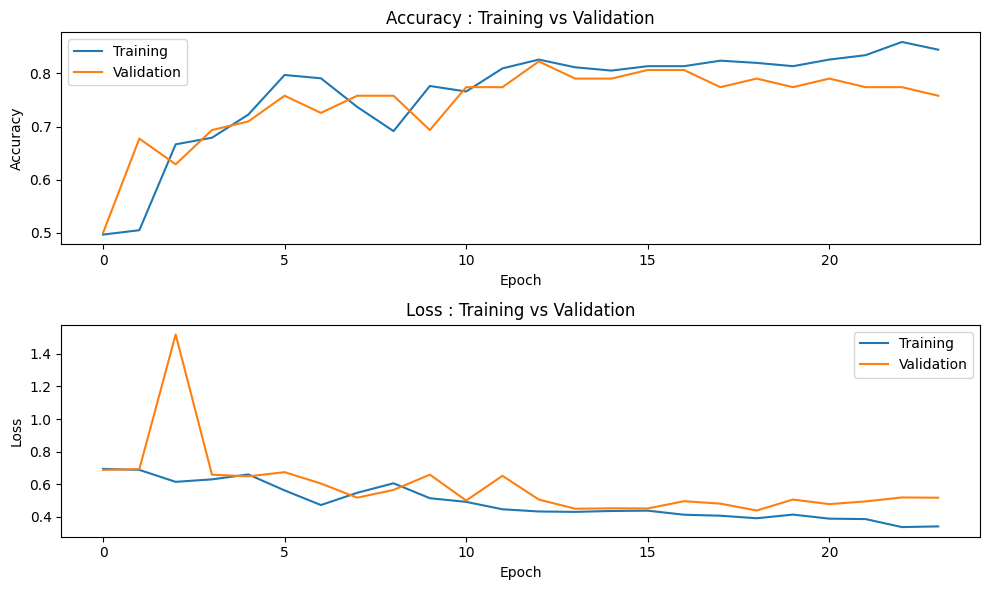

In [ ]:
# 예측 및 평가 메트릭 계산
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred))

if not isinstance(history, dict):
    history = history.history

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)

plt.subplot(2, 1, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.tight_layout()
plt.show()

## 증강 모델2

Found 483 images belonging to 2 classes.
Found 62 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Epoch 1/50
97/97 [==============================] - 41s 397ms/step - loss: 0.6824 - accuracy: 0.5321 - val_loss: 0.6456 - val_accuracy: 0.7097
Epoch 2/50
97/97 [==============================] - 31s 319ms/step - loss: 0.6635 - accuracy: 0.6501 - val_loss: 0.7739 - val_accuracy: 0.7097
Epoch 3/50
97/97 [==============================] - 32s 334ms/step - loss: 0.5999 - accuracy: 0.7226 - val_loss: 0.5685 - val_accuracy: 0.7581
Epoch 4/50
97/97 [==============================] - 31s 323ms/step - loss: 0.5205 - accuracy: 0.7971 - val_loss: 0.5510 - val_accuracy: 0.7581
Epoch 5/50
97/97 [==============================] - 41s 427ms/step - loss: 0.5370 - accuracy: 0.7536 - val_loss: 0.5038 - val_accuracy: 0.7742
Epoch 6/50
97/97 [==============================] - 31s 319ms/step - loss: 0.5362 - accuracy: 0.7205 - val_loss: 0.5411 - val_accuracy: 0.7419
Epoch 7/50
97/97 [===

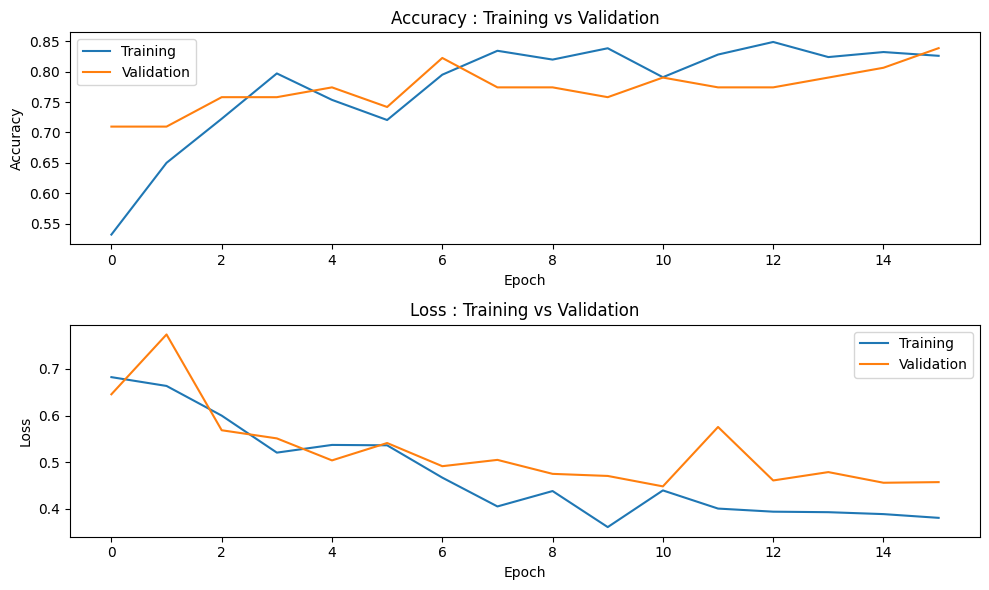

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator를 초기화합니다.
train_gen = ImageDataGenerator(
    rotation_range=90,      # 이미지 회전 각도 범위
    width_shift_range=0.2,  # 이미지 가로 이동 범위
    height_shift_range=0.2, # 이미지 세로 이동 범위
    shear_range=0.2,        # 전단변환 범위
    zoom_range=0.2,         # 이미지 확대/축소 범위
    horizontal_flip=True,   # 수평 뒤집기
    fill_mode='nearest',    # 이미지를 증강할 때 사용할 픽셀 채우기 방법
    rescale=1./255,         # 텐서의 모든 값을 rescale 값으로 나누어줌
)

valid_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

# 이미지 데이터를 불러올 경로 설정
train_path = path + 'Car_Images_train'
test_path = path + 'Car_Images_test'
val_path = path + 'Car_Images_val'

train_generator = train_gen.flow_from_directory(
    train_path,                 # 이미지 데이터를 불러올 디렉토리의 경로
    target_size=(280, 280),     # 이미지를 불러올 때 원하는 크기로 조정
    batch_size=2,               # 원본 이미지당 n개의 이미지를 생성
    class_mode='binary',
    classes=['normal', 'abnormal']
    save_dir =
)

valid_generator = valid_gen.flow_from_directory(
    val_path,
    target_size=(280, 280),
    class_mode='binary',
    classes=['normal', 'abnormal'],
    shuffle=False,
)

test_generator = test_gen.flow_from_directory(
    test_path,
    target_size=(280, 280),
    class_mode='binary',
    classes=['normal', 'abnormal'],
    shuffle=False,
)

# 모델 정의
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(280, 280, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)

# 모델 컴파일
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

# 모델 학습
history = model.fit(train_generator, validation_data=(valid_generator), epochs=50, callbacks=[early_stopping]) # generator가 생성하는 이미지만 학습하게 됩니다

# 예측 및 평가 메트릭 계산
y_pred = (model.predict(test_generator) > 0.5).astype(int)
print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred))

if not isinstance(history, dict):
    history = history.history

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)

plt.subplot(2, 1, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.tight_layout()
plt.show()

## VGG 모델1)

### (2) Transfer Learning
- **세부요구사항**
    * VGG16 모델은 1000개의 클래스를 분류하는 데 사용된 ImageNet 데이터셋을 기반으로 사전 학습된 가중치를 가지고 있습니다.
        * 따라서 이 모델은 이미지 분류 문제에 대한 높은 성능을 보입니다.
        * 이 모델은 보통 전이학습(transfer learning)에서 기본적으로 사용되며, 특히 대규모 데이터셋이 없을 때는 기본 모델로 사용되어 fine-tuning을 수행합니다.
    * VGG16 함수로 부터 base_model 저장


#### 1) VGG16 불러와서 저장하기
* include_top=False로 설정하여 분류기를 제외하고 미리 학습된 가중치 imagenet을 로드합니다.
* .trainable을 False로 설정하여 모델의 모든 레이어들을 Frozen 시켜 가중치를 고정합니다.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

base_model = VGG16(
    weights='imagenet',         # ImageNet 데이터셋으로 사전 학습된 가중치를 로드
    include_top=False,          # 모델의 마지막 Fully Connected 계층을 포함하지 않습니다.
    input_shape=(224, 224, 3)   # VGG16은 224x224 크기의 이미지를 기대
    )

base_model.summary()

for layer in base_model.layers:
    layer.trainable = False

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### 2) VGG16과 연결한 구조 설계
* VGG16을 불러와서 Flatten, Dense 등으로 레이어 연결하기

In [ ]:
x = GlobalAveragePooling2D()(base_model.output) # Global Average Pooling은 공간 차원(가로 및 세로)을 평균화하여 각 특성 맵(feature map)의 평균 값을 계산하는 연산입니다.
y = Dense(1, activation='sigmoid')(x)

model = Model(base_model.input, y)      # 기존의 VGG16 모델과 위에서 정의한 Fully Connected 레이어를 연결하여 새로운 모델(model)을 생성합니다.

model.summary()

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

#### 3) 학습
- **세부요구사항**
    - 모델 학습 과정에 알맞은 보조 지표를 사용하세요.
    - 데이터
        - Data Augmentation에서 생성한 ImageDataGenerator를 학습에 이용하세요.
        - Early Stopping을 반드시 사용하세요.
        - 최적의 가중치를 모델에 적용하세요.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000001)
# lr_reduction

history = model.fit(train_generator, validation_data=(valid_generator), epochs=50, callbacks=[early_stopping])

Epoch 1/50
97/97 [==============================] - 53s 538ms/step - loss: 0.6541 - accuracy: 0.6398 - val_loss: 0.5902 - val_accuracy: 0.7903
Epoch 2/50
97/97 [==============================] - 31s 320ms/step - loss: 0.5648 - accuracy: 0.8302 - val_loss: 0.5245 - val_accuracy: 0.8226
Epoch 3/50
97/97 [==============================] - 31s 318ms/step - loss: 0.4900 - accuracy: 0.8406 - val_loss: 0.4977 - val_accuracy: 0.7903
Epoch 4/50
97/97 [==============================] - 31s 319ms/step - loss: 0.4578 - accuracy: 0.8509 - val_loss: 0.4742 - val_accuracy: 0.7903
Epoch 5/50
97/97 [==============================] - 32s 327ms/step - loss: 0.4166 - accuracy: 0.8654 - val_loss: 0.4380 - val_accuracy: 0.8387
Epoch 6/50
97/97 [==============================] - 32s 325ms/step - loss: 0.4065 - accuracy: 0.8592 - val_loss: 0.4309 - val_accuracy: 0.8387
Epoch 7/50
97/97 [==============================] - 34s 346ms/step - loss: 0.4028 - accuracy: 0.8509 - val_loss: 0.4235 - val_accuracy: 0.8387

#### 4) 성능 평가

2/2 [==============================] - 8s 6s/step
[[29  1]
 [ 2 28]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        30
           1       0.97      0.93      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



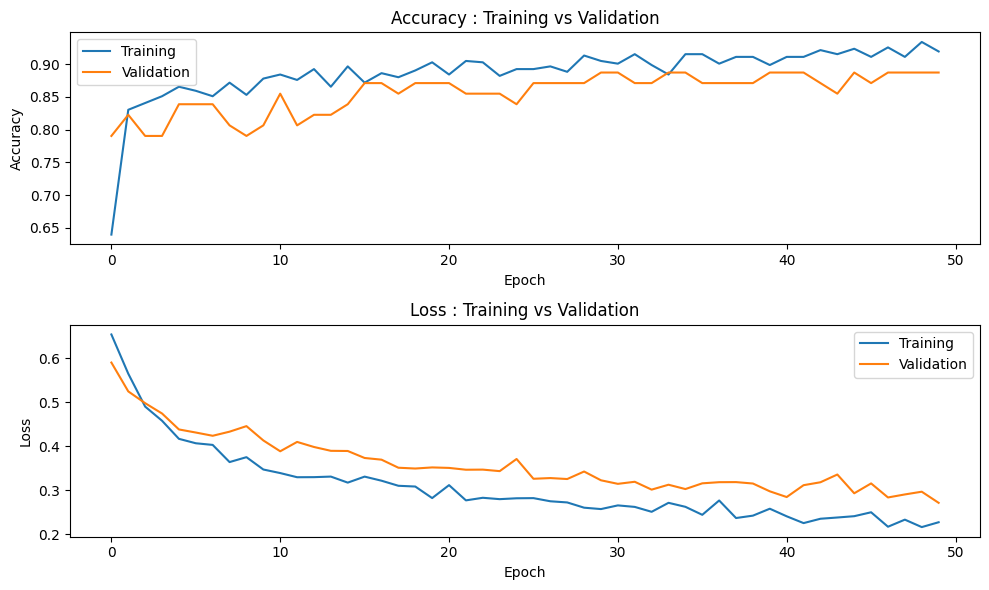

In [ ]:
# 예측 및 평가 메트릭 계산
y_pred = (model.predict(test_generator) > 0.5).astype(int)
print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred))

if not isinstance(history, dict):
    history = history.history

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)

plt.subplot(2, 1, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.tight_layout()
plt.show()

## VGG모델2)

In [33]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

base_model = VGG16(
    weights='imagenet',         # ImageNet 데이터셋으로 사전 학습된 가중치를 로드
    include_top=False,          # 모델의 마지막 Fully Connected 계층을 포함하지 않습니다.
    input_shape=(224, 224, 3)   # VGG16은 224x224 크기의 이미지를 기대
    )

for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)     # Global Average Pooling은 공간 차원(가로 및 세로)을 평균화하여 각 특성 맵(feature map)의 평균 값을 계산하는 연산입니다.
y = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=y)   # 기존의 VGG16 모델과 위에서 정의한 Fully Connected 레이어를 연결하여 새로운 모델(model)을 생성합니다.

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.summary()

history = model.fit(train_generator, validation_data=(valid_generator), epochs=50, callbacks=[early_stopping])



Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

NameError: ignored

2/2 [==============================] - 8s 6s/step
[[27  3]
 [ 2 28]]
              precision    recall  f1-score   support

           0       0.93      0.90      0.92        30
           1       0.90      0.93      0.92        30

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



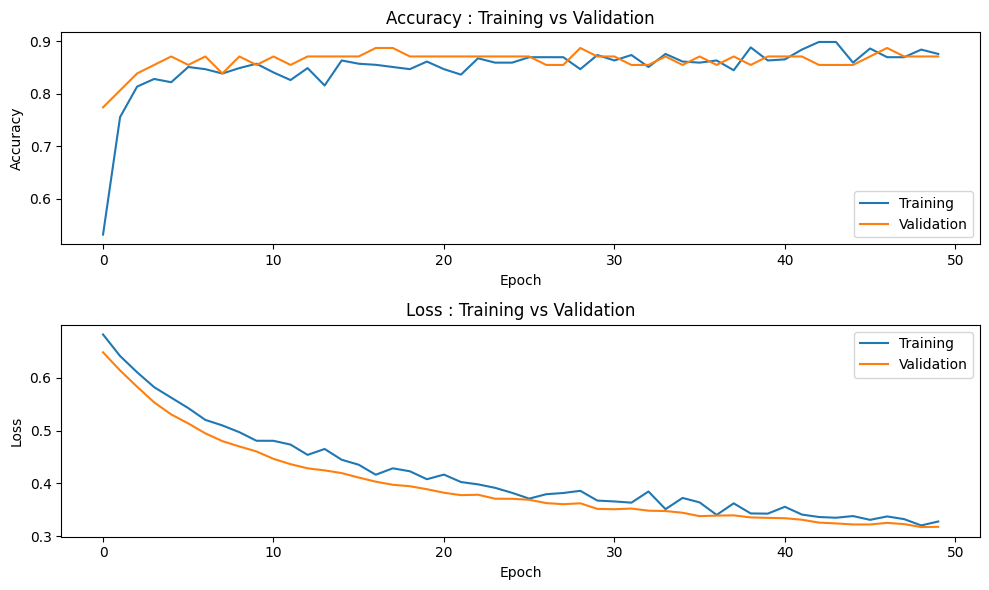

In [36]:
# 예측 및 평가 메트릭 계산
y_pred = (model.predict(test_generator) > 0.5).astype(int)
print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred))

if not isinstance(history, dict):
    history = history.history

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)

plt.subplot(2, 1, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.tight_layout()
plt.show()

## VGG모델3) NONO 증강

In [59]:
X_origin = []  # X_origin 원본 이미지 데이터를 저장할 빈 리스트

normal_data_1 =glob.glob(path+'normal/*')[:]
abnormal_data_2 = glob.glob(path+'abnormal/*')[:]

X_origin.extend(normal_data_1)
X_origin.extend(abnormal_data_2)

X_origin = load_and_preprocess_images(X_origin)

# Y_origin 데이터 생성
y_normal = [0] * len(glob.glob(path+'normal/*'))
y_abnormal = [1] * len(glob.glob(path+'abnormal/*'))

Y_origin = y_normal + y_abnormal

from sklearn.model_selection import train_test_split

# 이미지 데이터 경로가 담긴 X_origin 리스트를 train, validation, test 세트로 분할
X_train_origin, X_temp_origin, y_train_origin, y_temp_origin = train_test_split(X_origin, Y_origin, test_size=0.2, random_state=42, stratify=Y_origin)  # 8:2 비율로 train, temp로 분할

# 나머지 부분인 temp 세트를 validation과 test로 분할
X_validation_origin, X_test_origin, y_validation_origin, y_test_origin = train_test_split(X_temp_origin, y_temp_origin, test_size=0.5, random_state=42, stratify=y_temp_origin)  # 1:1 비율로 validation, test로 분할

y_train_origin = np.array(y_train_origin)
y_validation_origin = np.array(y_validation_origin)
y_test_origin = np.array(y_test_origin)

# 각 세트의 길이 확인
print("Train set size:", len(X_train_origin))
print("Validation set size:", len(X_validation_origin))
print("Test set size:", len(X_test_origin))

Train set size: 484
Validation set size: 60
Test set size: 61


Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 280, 280, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 280, 280, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 280, 280, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 140, 140, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 140, 140, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 140, 140, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 70, 70, 128)       0  

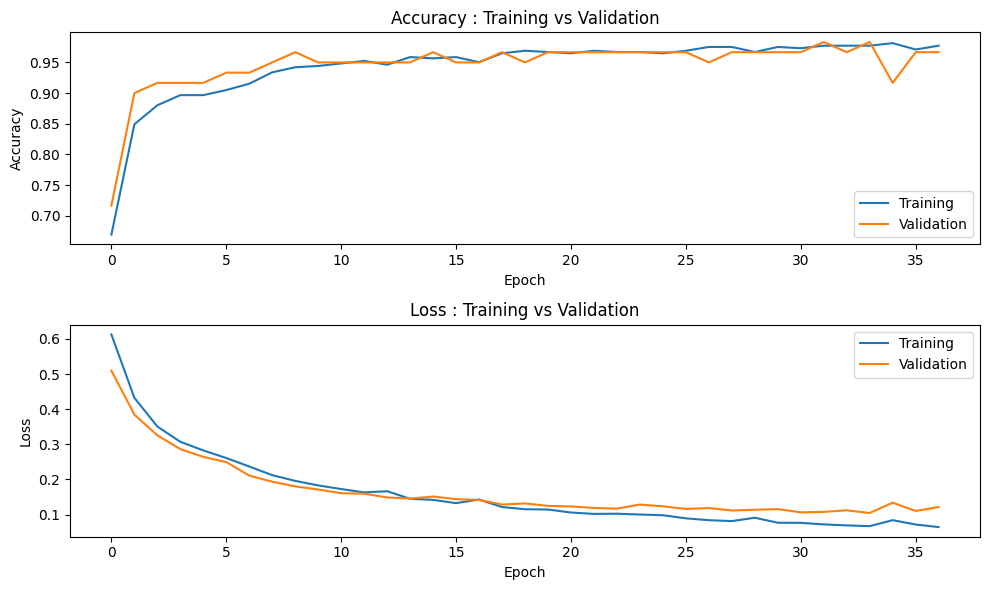

In [60]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten

base_model = VGG16(
    weights='imagenet',         # ImageNet 데이터셋으로 사전 학습된 가중치를 로드
    include_top=False,          # 모델의 마지막 Fully Connected 계층을 포함하지 않습니다.
    input_shape=(280, 280, 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)     # Global Average Pooling은 공간 차원(가로 및 세로)을 평균화하여 각 특성 맵(feature map)의 평균 값을 계산하는 연산입니다.
h = Flatten()(x)
h = Dense(128, activation='relu')(h)
y = Dense(1, activation='sigmoid')(h)

model = Model(inputs=base_model.input, outputs=y)   # 기존의 VGG16 모델과 위에서 정의한 Fully Connected 레이어를 연결하여 새로운 모델(model)을 생성합니다.

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.summary()

# 모델 학습
history = model.fit(X_train_origin, y_train_origin, validation_data=(X_validation_origin, y_validation_origin), epochs=50, callbacks=[early_stopping])

# 예측 및 평가 메트릭 계산
y_pred = (model.predict(X_test_origin) > 0.5).astype(int)
print(confusion_matrix(y_test_origin, y_pred))
print(classification_report(y_test_origin, y_pred))

if not isinstance(history, dict):
    history = history.history

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)

plt.subplot(2, 1, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.tight_layout()
plt.show()

## ConvNeXt 모델1) convnext_tiny

Model: "convnext_tiny"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 280, 280, 3)]        0         []                            
                                                                                                  
 convnext_tiny_prestem_norm  (None, 280, 280, 3)          0         ['input_11[0][0]']            
 alization (Normalization)                                                                        
                                                                                                  
 convnext_tiny_stem (Sequen  (None, 70, 70, 96)           4896      ['convnext_tiny_prestem_normal
 tial)                                                              ization[0][0]']               
                                                                                      

2/2 [==============================] - 7s 4s/step
[[23  7]
 [ 8 22]]
              precision    recall  f1-score   support

           0       0.74      0.77      0.75        30
           1       0.76      0.73      0.75        30

    accuracy                           0.75        60
   macro avg       0.75      0.75      0.75        60
weighted avg       0.75      0.75      0.75        60



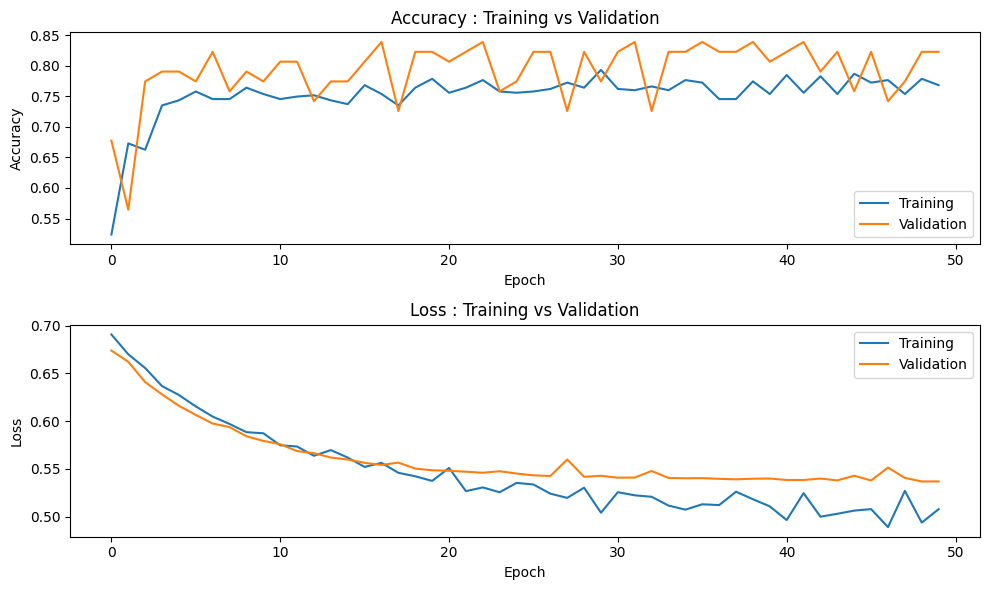

In [44]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ConvNeXtBase
import numpy as np
import tensorflow as tf
import keras

base_model = tf.keras.applications.ConvNeXtTiny(
    model_name="convnext_tiny",
    include_top=False,
    weights="imagenet",
    input_shape=(280, 280, 3)
)

base_model.summary()

for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
y = Dense(1, activation='sigmoid')(x)

model = Model(base_model.input, y)

model.summary()

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

x = GlobalAveragePooling2D()(base_model.output)
y = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=y)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_generator, validation_data=(valid_generator), epochs=50, callbacks=[early_stopping])

# 예측 및 평가 메트릭 계산
y_pred = (model.predict(test_generator) > 0.5).astype(int)
print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred))

if not isinstance(history, dict):
    history = history.history

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)

plt.subplot(2, 1, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense

# ConvNeXtBase 모델 아키텍처를 구현
input_tensor = Input(shape=(224, 224, 3))
# 여기에 ConvNeXtBase 모델의 레이어를 구현
# 예: Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense 레이어 등
# 모델 아키텍처를 구현한 후에는 Model로 모델을 정의
model = Model(inputs=input_tensor, outputs=output_tensor)


## ConvNeXt 모델2) convnext_base

Model: "convnext_base"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 280, 280, 3)]        0         []                            
                                                                                                  
 convnext_base_prestem_norm  (None, 280, 280, 3)          0         ['input_12[0][0]']            
 alization (Normalization)                                                                        
                                                                                                  
 convnext_base_stem (Sequen  (None, 70, 70, 128)          6528      ['convnext_base_prestem_normal
 tial)                                                              ization[0][0]']               
                                                                                      

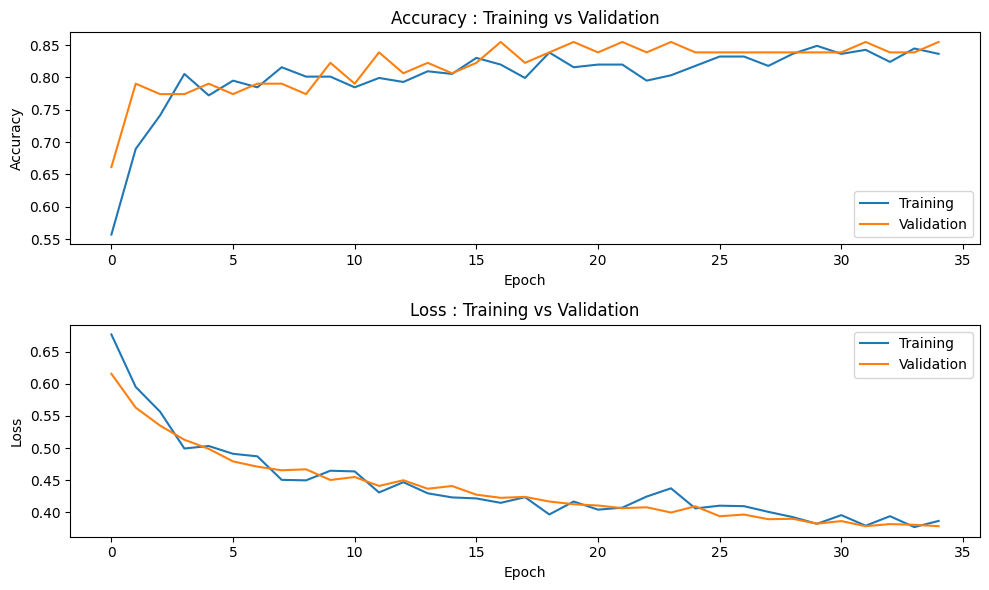

In [45]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ConvNeXtBase
import numpy as np
import tensorflow as tf
import keras

base_model = tf.keras.applications.ConvNeXtBase(
    model_name="convnext_base",
    include_top=False,
    weights="imagenet",
    input_shape=(280, 280, 3)
)
base_model.summary()

for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
y = Dense(1, activation='sigmoid')(x)

model = Model(base_model.input, y)

model.summary()

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

x = GlobalAveragePooling2D()(base_model.output)
y = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=y)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_generator, validation_data=(valid_generator), epochs=50, callbacks=[early_stopping])

# 예측 및 평가 메트릭 계산
y_pred = (model.predict(test_generator) > 0.5).astype(int)
print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred))

if not isinstance(history, dict):
    history = history.history

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)

plt.subplot(2, 1, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.tight_layout()
plt.show()

## EfficientNet 모델1) EfficientNetV2B0

24274472/24274472 [==============================] - 2s 0us/step
Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_14[0][0]']            
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          0         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2

<ipython-input-52-d3b574214c7c>:61: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  plt.tight_layout()
<ipython-input-52-d3b574214c7c>:61: UserWarning: Glyph 54253 (\N{HANGUL SYLLABLE POG}) missing from current font.
  plt.tight_layout()
<ipython-input-52-d3b574214c7c>:61: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  plt.tight_layout()
<ipython-input-52-d3b574214c7c>:61: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from current font.
  plt.tight_layout()
<ipython-input-52-d3b574214c7c>:61: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  plt.tight_layout()
<ipython-input-52-d3b574214c7c>:61: UserWarning: Glyph 54984 (\N{HANGUL SYLLABLE HUN}) missing from current font.
  plt.tight_layout()
<ipython-input-52-d3b574214c7c>:61: UserWarning: Glyph 47144 (\N{HANGUL SYLLABLE RYEON}) missing from current font.
  plt.tight_layout()
<ipython-input-52-d3b574214c7c>:61: UserWarning: Glyp

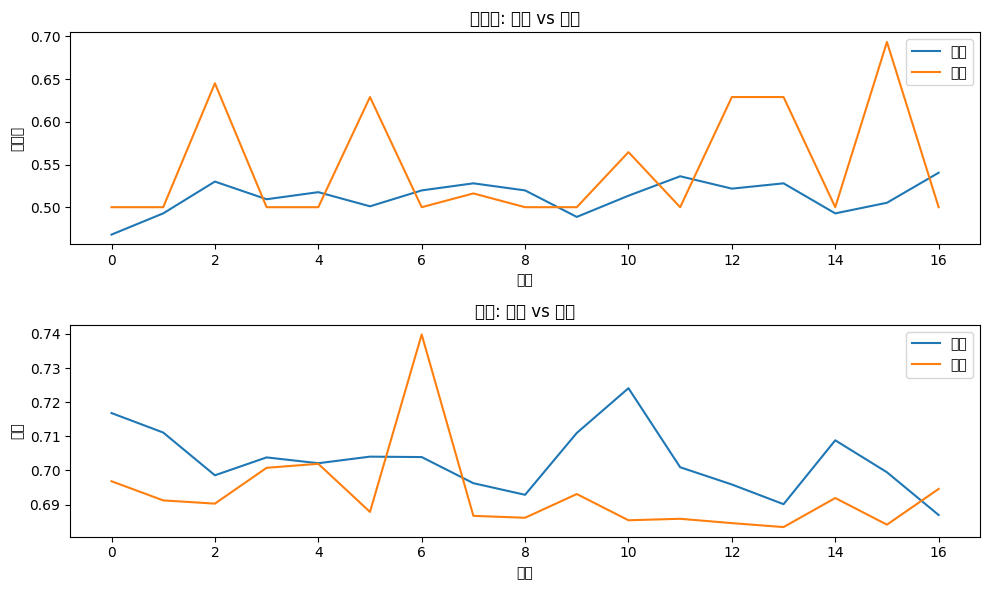

In [52]:
from tensorflow.keras.applications import EfficientNetV2B0  # EfficientNet 모델을 가져옵니다.
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam  # 사용하려는 최적화 기법을 가져옵니다.
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# EfficientNet의 기본 모델을 생성합니다.
base_model = EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)  # EfficientNet의 요구 사항에 맞게 입력 모양을 조정합니다.
)

base_model.summary()

# 기본 모델의 레이어를 동결합니다.
for layer in base_model.layers:
    layer.trainable = False

# 사용자 지정 분류 레이어를 추가합니다.
x = GlobalAveragePooling2D()(base_model.output)
y = Dense(1, activation='sigmoid')(x)

# 모델을 생성합니다.
model = Model(inputs=base_model.input, outputs=y)

# 모델을 컴파일합니다.
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# 훈련 및 평가 코드 (train_generator, valid_generator, test_generator, Y_test를 정의했는지 확인하세요)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_generator, validation_data=valid_generator, epochs=50, callbacks=[early_stopping])

y_pred = (model.predict(test_generator) > 0.5).astype(int)
print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred))

if not isinstance(history, dict):
    history = history.history

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('정확도: 훈련 vs 검증')
plt.ylabel('정확도')
plt.xlabel('에폭')
plt.legend(['훈련', '검증'], loc=0)

plt.subplot(2, 1, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('손실: 훈련 vs 검증')
plt.ylabel('손실')
plt.xlabel('에폭')
plt.legend(['훈련', '검증'], loc=0)
plt.tight_layout()
plt.show()